In [1]:
# =========================
# Step 0: Imports and Setup
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [2]:

# =========================
# Step 1: Load Data from BigQuery
# =========================
from google.cloud import bigquery
from google.colab import auth
auth.authenticate_user()
project_id = 'ecommerce-474706'
client = bigquery.Client(project=project_id)

tables_to_load = {
    "customers": "Customer_Profile_Demographics",
    "orders": "Order_Transaction_Master",
    "products": "Product_Catalog_Master",
    "product_review": "Product_Reviews_Ratings",
    "web_session": "Web_Session_Traffic",
    "user_clicks": "User_Interactions_Clicks",
    "cart_activity": "Shopping_Cart_Activity",
    "service_tickets": "Customer_Service_Tickets",
    "marketing": "Marketing_Campaign_Exposure",
    "returns": "Returns_Refunds_Logistics"
}

data = {}
for key, table in tables_to_load.items():
    query = f"SELECT * FROM `ecommerce-474706.ecommerce.{table}`"
    data[key] = client.query(query).to_dataframe()

# Assign variables
customers = data['customers']
orders = data['orders']
products = data['products']
product_review = data['product_review']
web_session = data['web_session']
user_clicks = data['user_clicks']
cart_activity = data['cart_activity']
service_tickets = data['service_tickets']
marketing = data['marketing']
returns = data['returns']

In [12]:
# =========================
# Step 2: Merge Orders, Customers, and Product Reviews
# =========================
product_review_full = product_review.merge(products, on='Product_ID', how='left')
orders_customers = orders.merge(customers, on='Customer_ID', how='left')
df_full = orders_customers.merge(product_review_full, on='Customer_ID', how='left')
df_full['Order_Date'] = pd.to_datetime(df_full['Order_Date'])
analysis_date = df_full['Order_Date'].max() + timedelta(days=1)

In [4]:

# =========================
# Step 3: RFM Segmentation
# =========================
rfm = df_full.groupby('Customer_ID').agg({
    'Order_Date': lambda x: (analysis_date - x.max()).days,
    'Order_ID': 'nunique',
    'Total_Amount_USD': 'sum'
}).reset_index()
rfm.rename(columns={'Order_Date':'Recency','Order_ID':'Frequency','Total_Amount_USD':'Monetary'}, inplace=True)
rfm['R_Score'] = pd.qcut(rfm['Recency'].rank(method='first'), 4, labels=[4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

def segment_customer(row):
    if row['RFM_Score'] in ['444','443','434']:
        return 'Champion'
    elif row['RFM_Score'] in ['111','112','121']:
        return 'Lost'
    elif row['RFM_Score'] in ['211','212','221']:
        return 'At-Risk'
    else:
        return 'Others'
rfm['Segment'] = rfm.apply(segment_customer, axis=1)
rfm_full = rfm.merge(customers, on='Customer_ID', how='left')

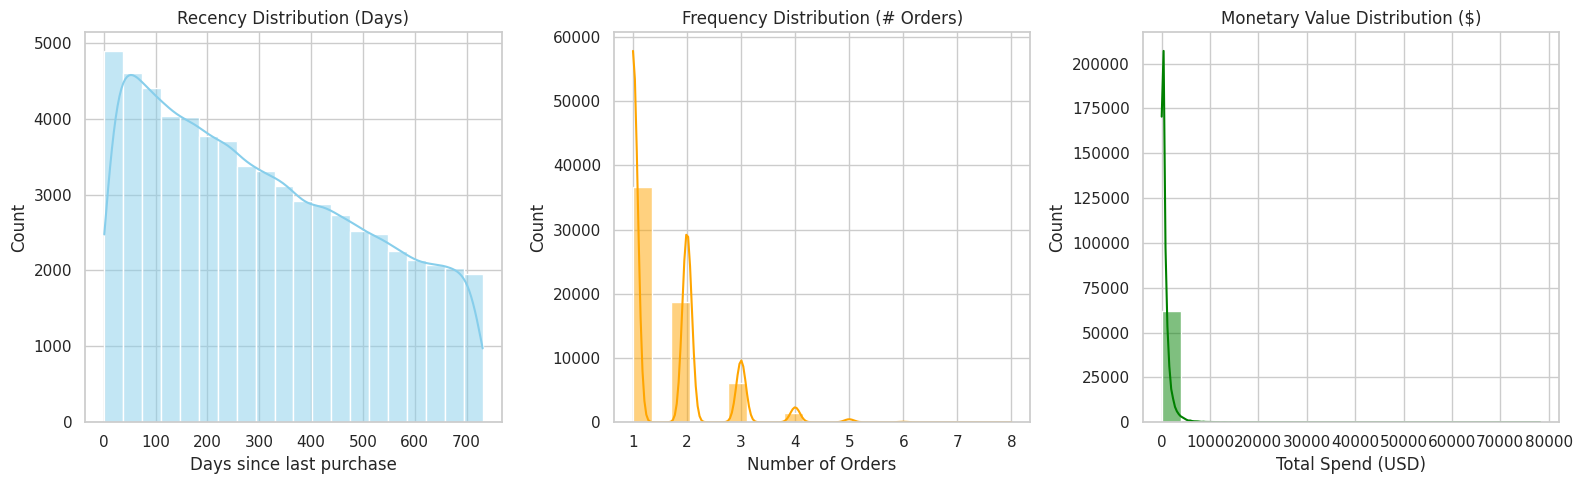

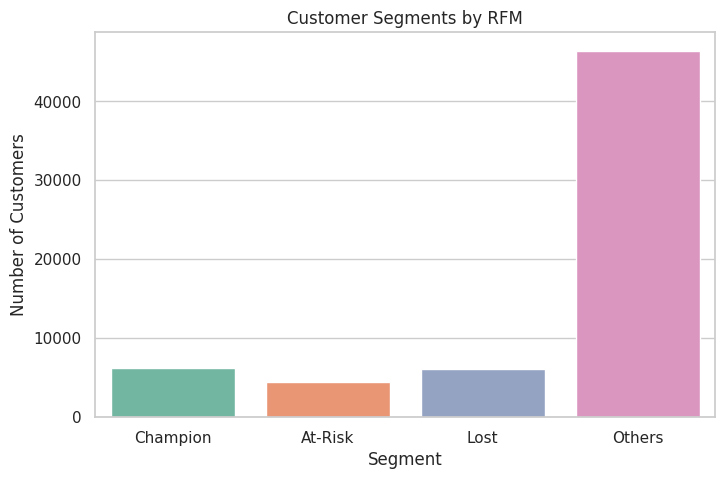

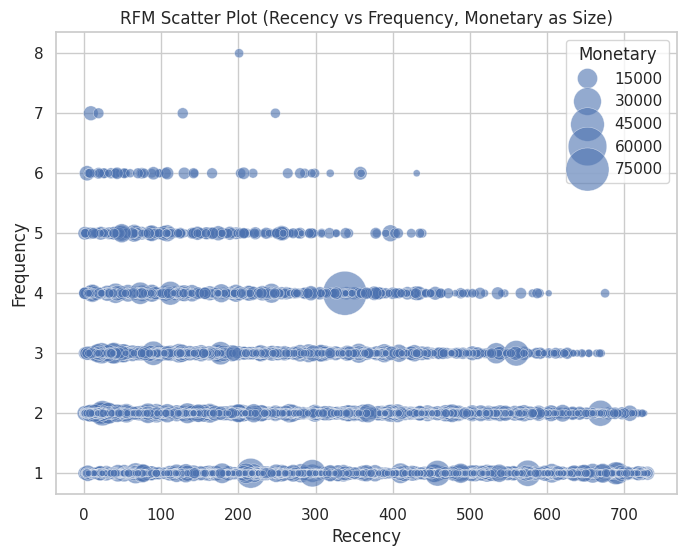

In [41]:
# =========================
# Step 4: RFM Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# --- 1️⃣ Distribution of Recency, Frequency, Monetary ---
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(rfm['Recency'], bins=20, kde=True, color='skyblue')
plt.title('Recency Distribution (Days)')
plt.xlabel('Days since last purchase')
plt.ylabel('Count')

plt.subplot(1,3,2)
sns.histplot(rfm['Frequency'], bins=20, kde=True, color='orange')
plt.title('Frequency Distribution (# Orders)')
plt.xlabel('Number of Orders')
plt.ylabel('Count')

plt.subplot(1,3,3)
sns.histplot(rfm['Monetary'], bins=20, kde=True, color='green')
plt.title('Monetary Value Distribution ($)')
plt.xlabel('Total Spend (USD)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# --- 2️⃣ Customer Segments Count ---
plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x='Segment', order=['Champion','At-Risk','Lost','Others'], palette='Set2')
plt.title('Customer Segments by RFM')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.show()

# --- 3️⃣ RFM 3D Bubble Scatter (optional, simple 2D version) ---
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', size='Monetary', alpha=0.6, sizes=(20, 1000))
plt.title('RFM Scatter Plot (Recency vs Frequency, Monetary as Size)')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

In [5]:
# =========================
# Step 4: Customer Lifetime Value (CLV)
# =========================
clv_df = df_full.groupby('Customer_ID').agg({
    'Order_ID':'nunique',
    'Total_Amount_USD':'sum',
    'Order_Date':[min,max]
}).reset_index()
clv_df.columns = ['Customer_ID','Frequency','Monetary','First_Purchase','Last_Purchase']
clv_df['Customer_Lifetime'] = (clv_df['Last_Purchase'] - clv_df['First_Purchase']).dt.days + 1
clv_df['AOV'] = clv_df['Monetary'] / clv_df['Frequency']
clv_df['CLV_Historical'] = clv_df['AOV'] * clv_df['Frequency']

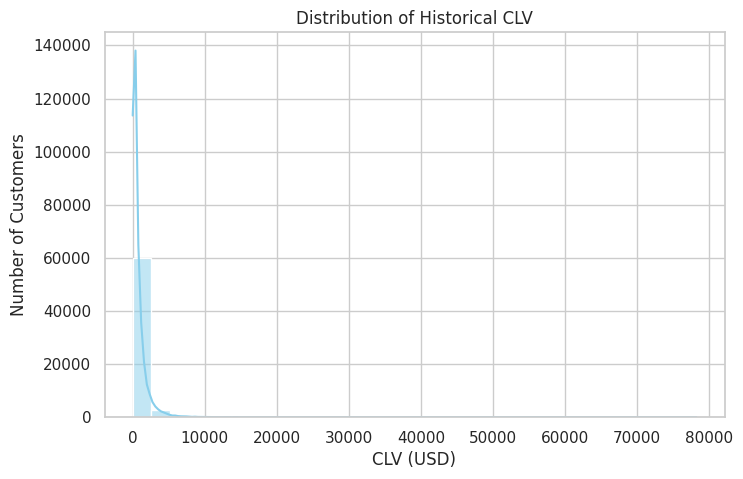

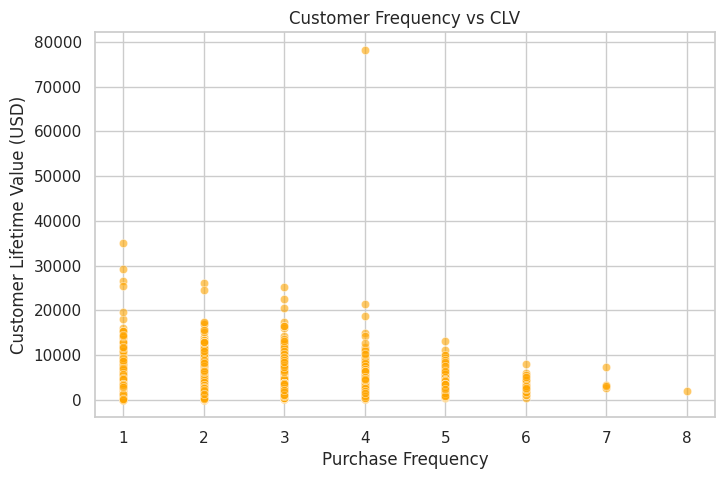

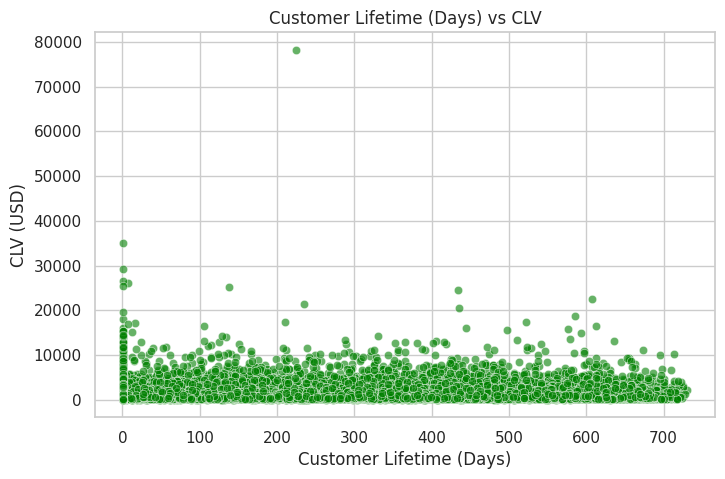

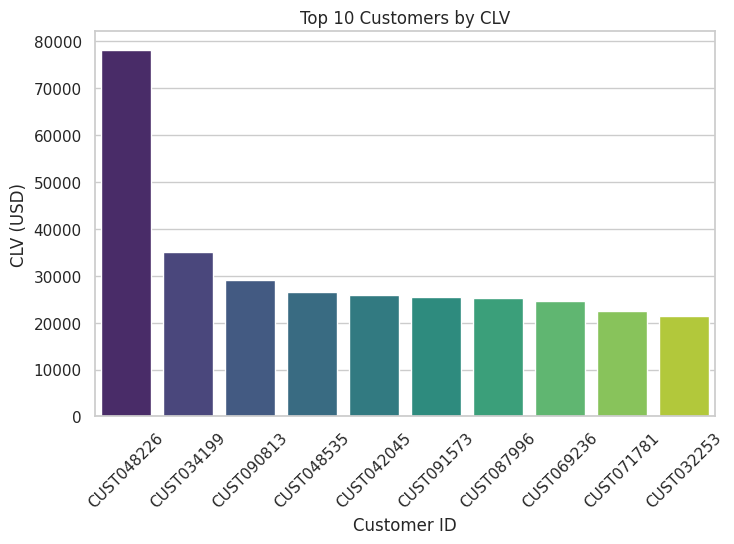

In [42]:
# =========================
# Step 5: CLV Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# --- 1️⃣ Distribution of Historical CLV ---
plt.figure(figsize=(8,5))
sns.histplot(clv_df['CLV_Historical'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Historical CLV')
plt.xlabel('CLV (USD)')
plt.ylabel('Number of Customers')
plt.show()

# --- 2️⃣ Relationship between Frequency and CLV ---
plt.figure(figsize=(8,5))
sns.scatterplot(data=clv_df, x='Frequency', y='CLV_Historical', alpha=0.6, color='orange')
plt.title('Customer Frequency vs CLV')
plt.xlabel('Purchase Frequency')
plt.ylabel('Customer Lifetime Value (USD)')
plt.show()

# --- 3️⃣ Customer Lifetime vs CLV ---
plt.figure(figsize=(8,5))
sns.scatterplot(data=clv_df, x='Customer_Lifetime', y='CLV_Historical', alpha=0.6, color='green')
plt.title('Customer Lifetime (Days) vs CLV')
plt.xlabel('Customer Lifetime (Days)')
plt.ylabel('CLV (USD)')
plt.show()

# --- 4️⃣ Top 10 High-Value Customers ---
top_customers = clv_df.sort_values(by='CLV_Historical', ascending=False).head(10)
plt.figure(figsize=(8,5))
sns.barplot(data=top_customers, x='Customer_ID', y='CLV_Historical', palette='viridis')
plt.title('Top 10 Customers by CLV')
plt.xticks(rotation=45)
plt.xlabel('Customer ID')
plt.ylabel('CLV (USD)')
plt.show()


In [6]:
# =========================
# Step 5: Churn Analysis
# =========================
customer_agg = df_full.groupby('Customer_ID').agg({
    'Order_Date':[min,max],
    'Order_ID':'nunique',
    'Total_Amount_USD':'sum'
}).reset_index()
customer_agg.columns = ['Customer_ID','First_Purchase','Last_Purchase','Frequency','Monetary']
customer_agg['Recency'] = (analysis_date - customer_agg['Last_Purchase']).dt.days
customer_agg['Churned'] = np.where(customer_agg['Recency']>180,1,0)

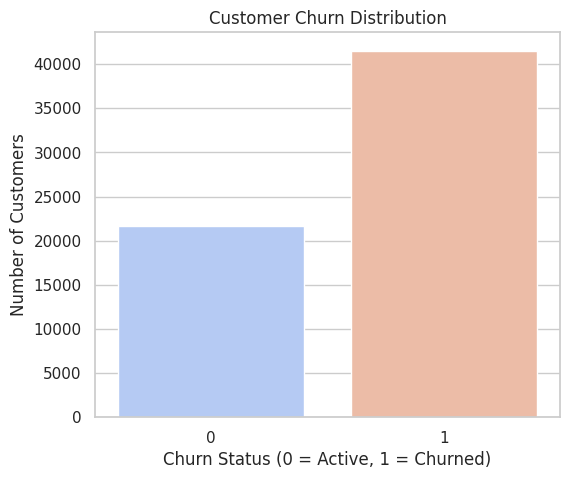

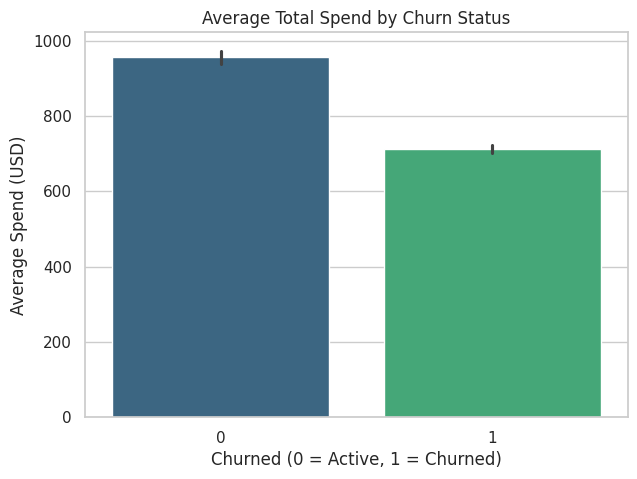

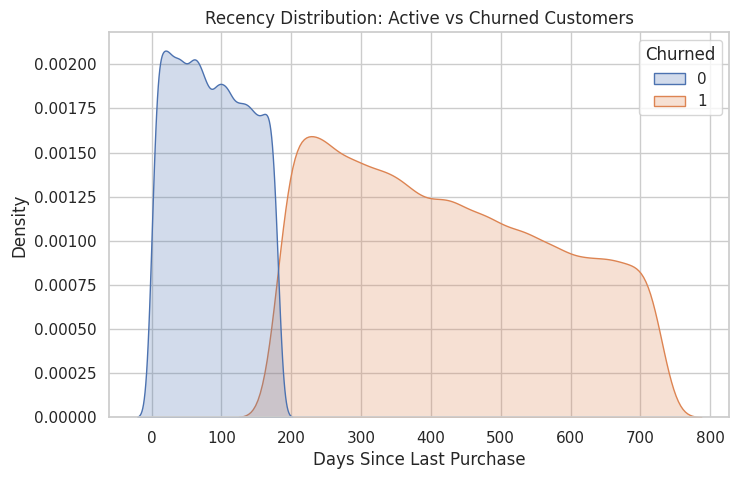

📉 Overall Churn Rate: 65.71%
💰 Revenue from Active Customers: $20,719,485.40
⚠️  Revenue Lost from Churned Customers: $29,637,325.30


In [44]:
# =========================
# Step 6: Churn Analysis Visualization & Insights
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# --- 1️⃣ Churn Distribution ---
plt.figure(figsize=(6,5))
sns.countplot(data=customer_agg, x='Churned', palette='coolwarm')
plt.title('Customer Churn Distribution')
plt.xlabel('Churn Status (0 = Active, 1 = Churned)')
plt.ylabel('Number of Customers')
plt.show()

# --- 2️⃣ Average Spend (Monetary) by Churn Status ---
plt.figure(figsize=(7,5))
sns.barplot(data=customer_agg, x='Churned', y='Monetary', palette='viridis')
plt.title('Average Total Spend by Churn Status')
plt.xlabel('Churned (0 = Active, 1 = Churned)')
plt.ylabel('Average Spend (USD)')
plt.show()

# --- 3️⃣ Recency Comparison (Active vs Churned) ---
plt.figure(figsize=(8,5))
sns.kdeplot(data=customer_agg, x='Recency', hue='Churned', fill=True)
plt.title('Recency Distribution: Active vs Churned Customers')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Density')
plt.show()

# --- 4️⃣ Overall Churn Rate ---
churn_rate = customer_agg['Churned'].mean() * 100
print(f"📉 Overall Churn Rate: {churn_rate:.2f}%")

# --- 5️⃣ Revenue Impact of Churn ---
lost_revenue = customer_agg.loc[customer_agg['Churned']==1, 'Monetary'].sum()
active_revenue = customer_agg.loc[customer_agg['Churned']==0, 'Monetary'].sum()

print(f"💰 Revenue from Active Customers: ${active_revenue:,.2f}")
print(f"⚠️  Revenue Lost from Churned Customers: ${lost_revenue:,.2f}")


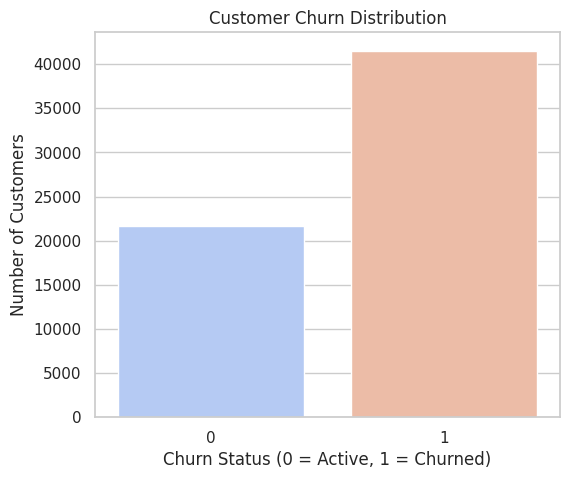

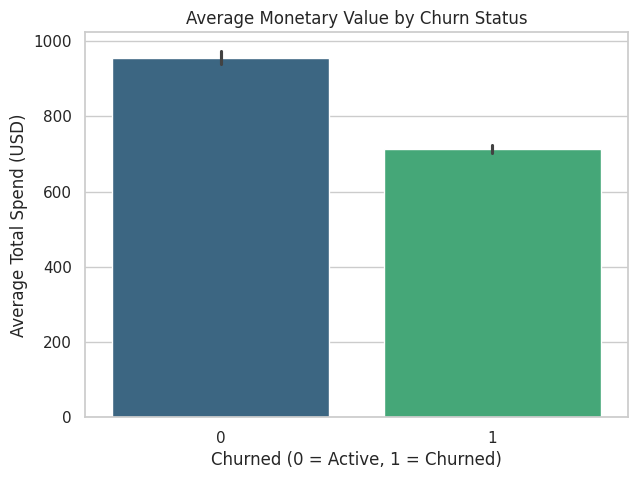

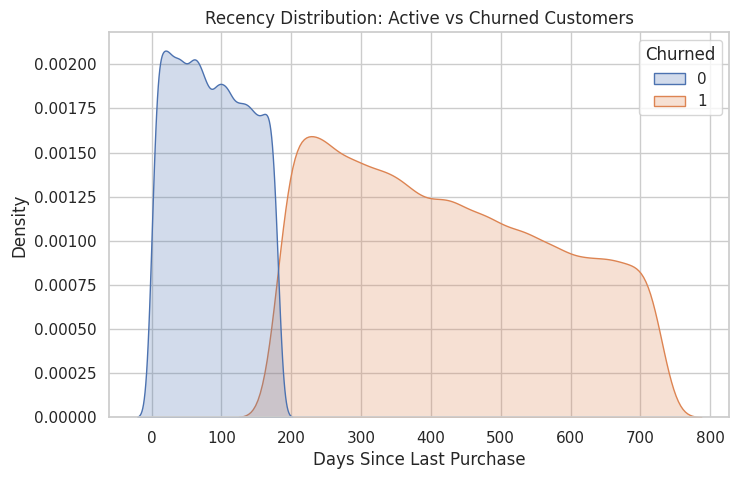

Overall Churn Rate: 65.71%
Revenue from Active Customers: $20,719,485.40
Revenue Lost to Churned Customers: $29,637,325.30


In [43]:
# =========================
# Step 6: Churn Visualization & Insights
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# --- 1️⃣ Churn Distribution ---
plt.figure(figsize=(6,5))
sns.countplot(data=customer_agg, x='Churned', palette='coolwarm')
plt.title('Customer Churn Distribution')
plt.xlabel('Churn Status (0 = Active, 1 = Churned)')
plt.ylabel('Number of Customers')
plt.show()

# --- 2️⃣ Average Monetary Value by Churn Status ---
plt.figure(figsize=(7,5))
sns.barplot(data=customer_agg, x='Churned', y='Monetary', palette='viridis')
plt.title('Average Monetary Value by Churn Status')
plt.xlabel('Churned (0 = Active, 1 = Churned)')
plt.ylabel('Average Total Spend (USD)')
plt.show()

# --- 3️⃣ Recency Comparison (Active vs Churned) ---
plt.figure(figsize=(8,5))
sns.kdeplot(data=customer_agg, x='Recency', hue='Churned', fill=True)
plt.title('Recency Distribution: Active vs Churned Customers')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Density')
plt.show()

# --- 4️⃣ Churn Rate ---
churn_rate = customer_agg['Churned'].mean() * 100
print(f"Overall Churn Rate: {churn_rate:.2f}%")

# --- 5️⃣ Monetary Loss Due to Churn ---
lost_revenue = customer_agg.loc[customer_agg['Churned']==1, 'Monetary'].sum()
active_revenue = customer_agg.loc[customer_agg['Churned']==0, 'Monetary'].sum()
print(f"Revenue from Active Customers: ${active_revenue:,.2f}")
print(f"Revenue Lost to Churned Customers: ${lost_revenue:,.2f}")


In [7]:
# Step 6: Loyalty Tiers
# =========================
def loyalty_tier(row):
    if row['RFM_Score'] in ['444','443','434']:
        return 'Platinum'
    elif row['RFM_Score'] in ['344','334','343','433']:
        return 'Gold'
    elif row['RFM_Score'] in ['222','223','232','322','323']:
        return 'Silver'
    else:
        return 'Bronze'
rfm_full = rfm_full.merge(clv_df[['Customer_ID','AOV']], on='Customer_ID', how='left')
rfm_full['Loyalty_Tier'] = rfm_full.apply(loyalty_tier, axis=1)

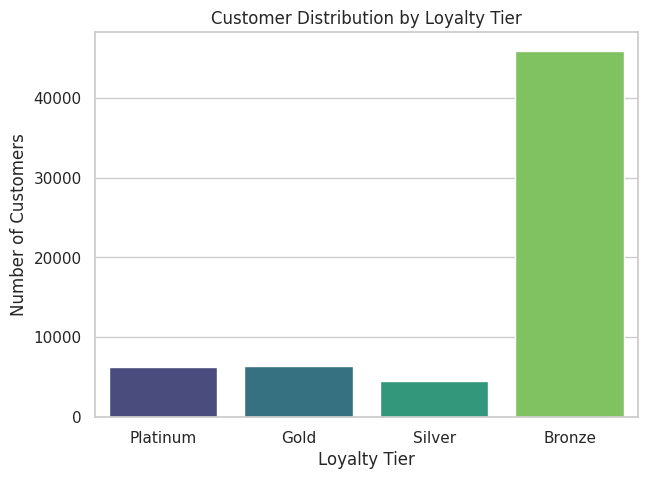

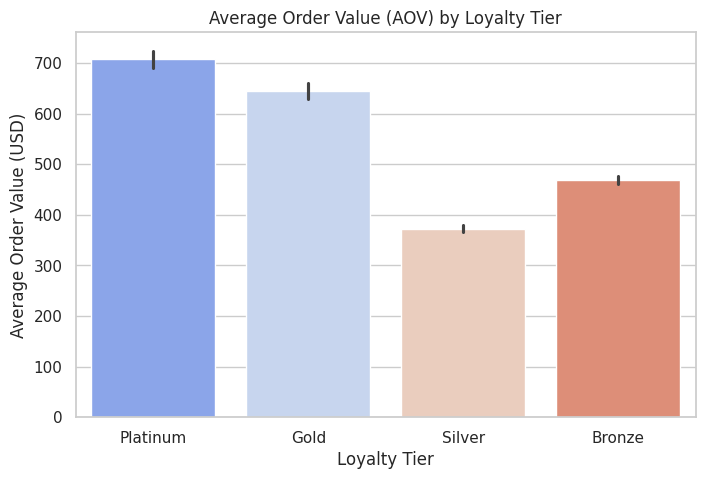

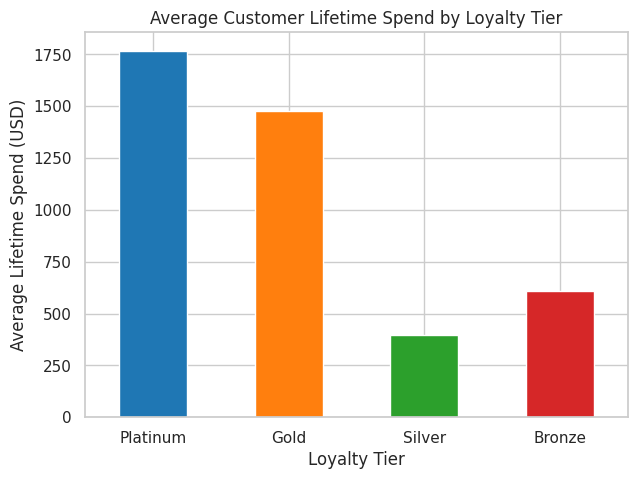

📊 Loyalty Tier Summary:
  Loyalty_Tier  Customer_Count     Monetary         AOV  Frequency
0       Bronze           45897   608.286580  469.314924   1.353444
1         Gold            6442  1476.587827  644.523733   2.423161
2     Platinum            6280  1768.834185  707.565055   2.704936
3       Silver            4598   395.351042  372.829066   1.149195


In [45]:
# =========================
# Step 6B: Loyalty Tier Visualization & Insights
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# --- 1️⃣ Tier Distribution ---
plt.figure(figsize=(7,5))
sns.countplot(data=rfm_full, x='Loyalty_Tier', order=['Platinum','Gold','Silver','Bronze'], palette='viridis')
plt.title('Customer Distribution by Loyalty Tier')
plt.xlabel('Loyalty Tier')
plt.ylabel('Number of Customers')
plt.show()

# --- 2️⃣ Average AOV per Tier ---
plt.figure(figsize=(8,5))
sns.barplot(data=rfm_full, x='Loyalty_Tier', y='AOV', order=['Platinum','Gold','Silver','Bronze'], palette='coolwarm')
plt.title('Average Order Value (AOV) by Loyalty Tier')
plt.xlabel('Loyalty Tier')
plt.ylabel('Average Order Value (USD)')
plt.show()

# --- 3️⃣ Average Monetary Value per Tier ---
tier_value = (
    rfm_full.groupby('Loyalty_Tier')['Monetary']
    .mean()
    .reindex(['Platinum','Gold','Silver','Bronze'])
)

plt.figure(figsize=(7,5))
tier_value.plot(kind='bar', color=['#1f77b4','#ff7f0e','#2ca02c','#d62728'])
plt.title('Average Customer Lifetime Spend by Loyalty Tier')
plt.xlabel('Loyalty Tier')
plt.ylabel('Average Lifetime Spend (USD)')
plt.xticks(rotation=0)
plt.show()

# --- 4️⃣ Summary Table ---
tier_summary = rfm_full.groupby('Loyalty_Tier').agg({
    'Customer_ID':'count',
    'Monetary':'mean',
    'AOV':'mean',
    'Frequency':'mean'
}).rename(columns={'Customer_ID':'Customer_Count'}).reset_index()

print("📊 Loyalty Tier Summary:")
print(tier_summary)


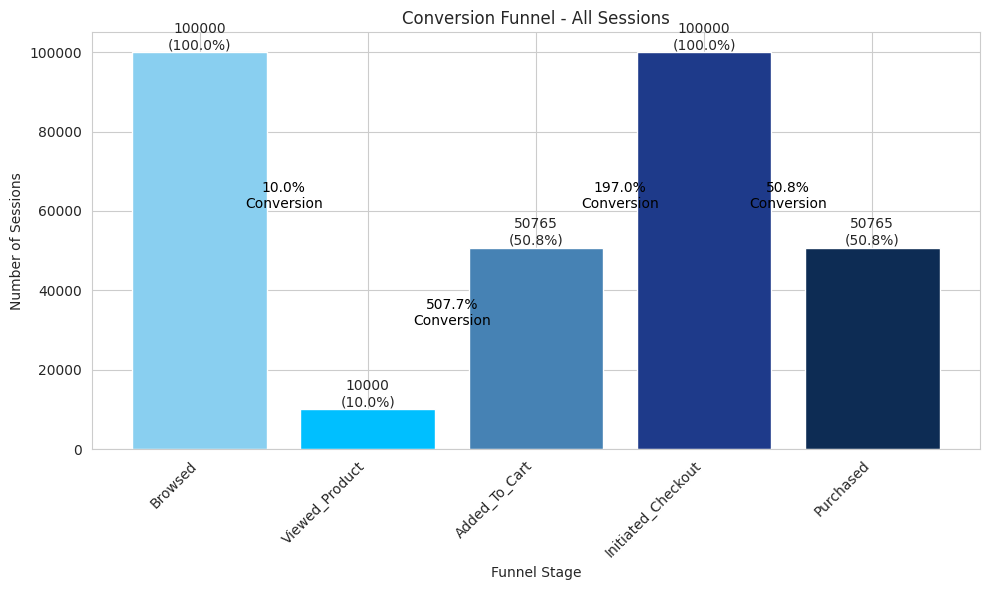

In [8]:
# Step 7: Conversion Funnel Analysis
# =========================
# Merge funnel tables
funnel = web_session.merge(user_clicks, on='Session_ID', how='left', suffixes=('_session', '_clicks'))
# Rename the Customer_ID column from web_session to Customer_ID for subsequent merges
funnel.rename(columns={'Customer_ID_session': 'Customer_ID'}, inplace=True)
funnel = funnel.merge(cart_activity, on='Customer_ID', how='left')
funnel = funnel.merge(orders[['Customer_ID','Order_ID']], on='Customer_ID', how='left')


# Funnel stage counts
stage_counts = [
    web_session['Session_ID'].nunique(),
    funnel['Session_ID'][funnel['Interaction_ID'].notnull()].nunique(),
    funnel['Session_ID'][funnel['Cart_Event_ID'].notnull()].nunique(),
    funnel['Session_ID'][funnel['Checkout_Steps_Completed__Checkout_Flow_2'].notnull()].nunique(),
    funnel['Session_ID'][funnel['Order_ID'].notnull()].nunique()
]
funnel_stages = ['Browsed', 'Viewed_Product', 'Added_To_Cart', 'Initiated_Checkout', 'Purchased']

# Percentages & conversion rates
total_sessions = stage_counts[0]
stage_percentages = [count / total_sessions for count in stage_counts]
conversion_rates_list = [1.0] + [stage_counts[i+1]/stage_counts[i] if stage_counts[i]>0 else 0 for i in range(len(stage_counts)-1)]

# Plot funnel
plt.figure(figsize=(10, 6))
bars = plt.bar(funnel_stages, stage_counts, color=['#89CFF0','#00BFFF','#4682B4','#1E3A8A', '#0D2C54'])
plt.title('Conversion Funnel - All Sessions')
plt.ylabel('Number of Sessions')
plt.xlabel('Funnel Stage')
plt.xticks(rotation=45, ha='right')
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval}\n({stage_percentages[i]:.1%})', va='bottom', ha='center')
for i in range(len(funnel_stages) - 1):
    x = i + 0.5
    y = max(stage_counts[i], stage_counts[i+1]) * 0.6
    plt.text(x, y, f'{conversion_rates_list[i+1]:.1%}\nConversion', ha='center', va='bottom', color='black', fontsize=10)
plt.tight_layout()
plt.show()

In [9]:

# =========================# Step 8: Market Basket Analysis (Memory Optimized)
# =========================
# Filter top 1000 products to avoid RAM crash
top_products = df_full['Product_ID'].value_counts().head(1000).index.tolist()
df_filtered = df_full[df_full['Product_ID'].isin(top_products)]

# Create basket using crosstab (sparse and memory-efficient)
basket = pd.crosstab(df_filtered['Order_ID'], df_filtered['Product_ID'])
basket = basket.applymap(lambda x: 1 if x>0 else 0)

# # Apriori
# frequent_itemsets = apriori(basket, min_support=0.001, use_colnames=True)
# rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.2)
# top_rules = rules.sort_values('lift', ascending=False)[['antecedents','consequents','support','confidence','lift']].head(10)


In [10]:



# =========================
# Step 9: Cannibalization/Complementarity
# =========================
df_full['Month'] = df_full['Order_Date'].dt.to_period('M')
monthly_sales = df_full.groupby(['Month','Product_ID'])['Total_Amount_USD'].sum().reset_index()
category_name = 'Electronics'  # Example
category_products = products[products['Category']==category_name]['Product_ID'].tolist()[:2]
sales_compare = monthly_sales[monthly_sales['Product_ID'].isin(category_products)]
sales_pivot = sales_compare.pivot(index='Month', columns='Product_ID', values='Total_Amount_USD').fillna(0)
corr_matrix = sales_pivot.corr()
print("Correlation between selected products:")
print(corr_matrix)

# =========================


Correlation between selected products:
Product_ID  PROD000058  PROD000067
Product_ID                        
PROD000058    1.000000   -0.769646
PROD000067   -0.769646    1.000000


In [17]:

# Rename it to Price_USD for consistency
df_full.rename(columns={'Unit_Price':'Price_USD'}, inplace=True)


In [20]:
# Step 10: Price Elasticity
# Top 5 categories by total sales
top_categories = df_full.groupby('Category')['Total_Amount_USD'].sum().sort_values(ascending=False).head(5).index.tolist()
elasticity = {}

# Loop through each top category
for cat in top_categories:
    cat_data = df_full[df_full['Category']==cat]

    # Use Retail_Price instead of Price_USD
    price_qty = cat_data.groupby('Product_ID')[['Retail_Price','Order_ID']].agg({'Retail_Price':'mean','Order_ID':'count'}).reset_index()

    # Percent change in quantity and price
    price_qty['pct_qty'] = price_qty['Order_ID'].pct_change()
    price_qty['pct_price'] = price_qty['Retail_Price'].pct_change()

    # Drop NA values created due to pct_change
    price_qty = price_qty.dropna()

    # Price Elasticity = %ΔQ / %ΔP
    price_qty['elasticity'] = price_qty['pct_qty'] / price_qty['pct_price']

    # Average elasticity for category
    elasticity[cat] = price_qty['elasticity'].mean()

print("Price elasticity per top category:")
print(elasticity)


Price elasticity per top category:
{'Apparel': np.float64(-12.255182516021232), 'Electronics': np.float64(-0.5051454433751338), 'Home Goods': np.float64(0.1739227166404844), 'Beauty': np.float64(-4.2116224778137825), 'Books': np.float64(2.8762676600209045)}


In [21]:
# =========================
# Step 8: Price Elasticity
# =========================

# Top 5 categories by total sales
top_categories = df_full.groupby('Category')['Total_Amount_USD'].sum().sort_values(ascending=False).head(5).index.tolist()
elasticity = {}

# Loop through each top category
for cat in top_categories:
    # Filter data for current category
    cat_data = df_full[df_full['Category'] == cat]

    # Aggregate per product: average Retail_Price and total orders (as quantity proxy)
    price_qty = cat_data.groupby('Product_ID')[['Retail_Price','Order_ID']].agg({'Retail_Price':'mean','Order_ID':'count'}).reset_index()

    # Compute percent change in quantity and price
    price_qty['pct_qty'] = price_qty['Order_ID'].pct_change()
    price_qty['pct_price'] = price_qty['Retail_Price'].pct_change()

    # Drop NA values generated by pct_change()
    price_qty = price_qty.dropna()

    # Calculate price elasticity = %ΔQ / %ΔP
    price_qty['elasticity'] = price_qty['pct_qty'] / price_qty['pct_price']

    # Take mean elasticity for the category
    elasticity[cat] = price_qty['elasticity'].mean()

# Display price elasticity per top category
print("Price Elasticity for Top 5 Categories:")
for cat, el in elasticity.items():
    print(f"{cat}: {round(el, 3)}")


Price Elasticity for Top 5 Categories:
Apparel: -12.255
Electronics: -0.505
Home Goods: 0.174
Beauty: -4.212
Books: 2.876


In [23]:
print(marketing.columns.tolist())


['Exposure_ID', 'Campaign_ID', 'Customer_ID', 'Exposure_Date', 'Marketing_Channel', 'Ad_Impressions', 'Clicks_Count', 'CTR_Rate', 'Conversion_Flag', 'Conversion_Value_USD', 'Channel_Cost_Per_Exposure_USD', 'Landing_Page_Variant', 'Time_Since_Last_Exposure_Days', 'Creative_ID', 'Target_Audience_Segment', 'Video_View__Facebook_1', 'Attribution_Model__Google_2', 'Bid_Price__Google_3', 'Video_View__LeadGen_4', 'Total_Interaction_Time__Facebook_5', 'Engagement_Quality_Index__Retargeting_6', 'Email_Open__Facebook_7', 'Video_View__Google_8', 'Bid_Price__Acquisition_9', 'Engagement_Quality_Index__Facebook_10', 'Total_Interaction_Time__Google_11', 'Total_Interaction_Time__Retargeting_12', 'Bid_Price__Retargeting_13', 'Engagement_Quality_Index__SearchTerm_14', 'Email_Open__Google_15', 'Social_Share_Count__SearchTerm_16', 'Attribution_Model__Google_17', 'Bid_Price__SearchTerm_18', 'Video_View__Facebook_19', 'Social_Share_Count__Facebook_20', 'Frequency_Cap_Count__SearchTerm_21', 'Engagement_Quali

In [24]:
# =========================
# Step 9: Attribution Modeling (ROAS)
# =========================

# Merge marketing exposure with orders to get revenue per customer
marketing_orders = marketing.merge(
    orders[['Customer_ID','Total_Amount_USD']],
    on='Customer_ID',
    how='left'
)

# Group by Marketing_Channel to calculate ROAS
roas_summary = marketing_orders.groupby('Marketing_Channel').agg({
    'Channel_Cost_Per_Exposure_USD':'sum',  # Total spend per channel
    'Total_Amount_USD':'sum'                 # Total revenue generated
}).reset_index()

# ROAS = Revenue / Spend
roas_summary['ROAS'] = roas_summary['Total_Amount_USD'] / roas_summary['Channel_Cost_Per_Exposure_USD']

# Sort channels by ROAS descending
roas_summary = roas_summary.sort_values('ROAS', ascending=False)

print("Return on Ad Spend (ROAS) per Marketing Channel:")
print(roas_summary)


Return on Ad Spend (ROAS) per Marketing Channel:
  Marketing_Channel  Channel_Cost_Per_Exposure_USD  Total_Amount_USD  \
0         Affiliate                      9914.9558       10002317.96   
1        Display Ad                     15116.1724       15200355.25   
2             Email                     30178.2577       30273096.74   
3         Search Ad                     25162.7695       25079879.15   
4         Social Ad                     20147.7590       19851648.36   

          ROAS  
0  1008.811150  
1  1005.569059  
2  1003.142628  
3   996.705834  
4   985.303048  


Impact of CX Issues on Repeat Purchase within 30 Days:
        Issue_Type  Repeat_Purchase_Rate
0    Billing Error              0.521964
4   Shipping Issue              0.521459
5   Technical Help              0.518491
2     Order Status              0.518437
3   Product Defect              0.517885
1  General Inquiry              0.511850


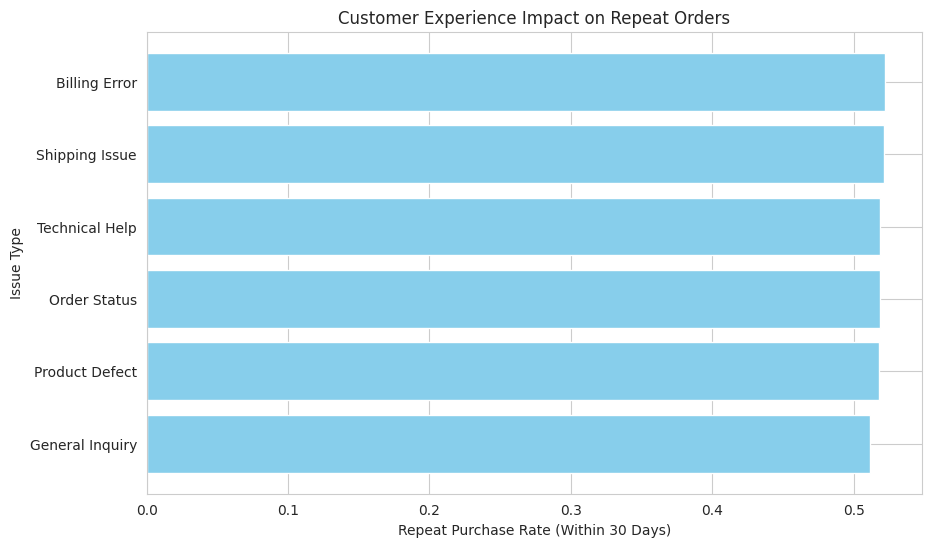

In [25]:
# =========================
# Step 10: Impact of Customer Experience (CX)
# =========================

# Merge service tickets with orders to know which customer had issues
service_orders = service_tickets.merge(
    orders[['Customer_ID','Order_ID','Order_Date']],
    on='Customer_ID',
    how='left'
)

# Define repeat purchase within 30 days
# Step 1: find the next order date per customer
service_orders = service_orders.sort_values(['Customer_ID','Order_Date'])
service_orders['Next_Order_Date'] = service_orders.groupby('Customer_ID')['Order_Date'].shift(-1)

# Step 2: flag if next order happened within 30 days of the current order
service_orders['Repeat_Within_30D'] = (service_orders['Next_Order_Date'] - service_orders['Order_Date']).dt.days <= 30
service_orders['Repeat_Within_30D'] = service_orders['Repeat_Within_30D'].fillna(False)

# Step 3: Analyze repeat rate by Issue_Type
cx_impact = service_orders.groupby('Issue_Type')['Repeat_Within_30D'].mean().reset_index()
cx_impact.rename(columns={'Repeat_Within_30D':'Repeat_Purchase_Rate'}, inplace=True)
cx_impact = cx_impact.sort_values('Repeat_Purchase_Rate', ascending=False)

print("Impact of CX Issues on Repeat Purchase within 30 Days:")
print(cx_impact)

# Optional: visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(cx_impact['Issue_Type'], cx_impact['Repeat_Purchase_Rate'], color='skyblue')
plt.xlabel('Repeat Purchase Rate (Within 30 Days)')
plt.ylabel('Issue Type')
plt.title('Customer Experience Impact on Repeat Orders')
plt.gca().invert_yaxis()
plt.show()


In [27]:
# Check column names
print(product_review.columns)


Index(['Review_ID', 'Product_ID', 'Customer_ID', 'Review_Date', 'Rating',
       'Review_Length_Chars', 'Helpfulness_Votes_Count',
       'Is_Verified_Purchase_Flag', 'Review_Title', 'Base_Sentiment_Score',
       ...
       'NLP_Neutral__ModelA_91', 'Token_Unique__ModelA_92',
       'Token_Unique__Material_93', 'Emotion_Joy__Material_94',
       'Profanity__Logistics_95', 'Text_Clarity__Material_96',
       'Profanity__BERT_97', 'Text_Clarity__Logistics_98',
       'Topic_Fit__FeatureSet_99', 'Token_Unique__Material_100'],
      dtype='object', length=115)


In [31]:
# Dekhne ke liye orders table me kaunse columns hain
print(orders.columns)


Index(['Order_ID', 'Customer_ID', 'Order_Date', 'Order_Status',
       'Total_Amount_USD', 'Total_Items_Count', 'Payment_Method',
       'Shipping_Type', 'Shipping_Cost_USD', 'Coupon_Code_Used',
       ...
       'Product_Returns__Apparel_91', 'Customer_Service_Contact__Apparel_92',
       'Order_Refunded_Flag__Electronics_93',
       'Payment_Transaction_Fee__Regional_94',
       'Customer_Service_Contact__Priority_95',
       'Payment_Transaction_Fee__ReturnsPolicy_96',
       'Order_Refunded_Flag__Priority_97',
       'Warehouse_Location_Code__Electronics_98',
       'Order_Refunded_Flag__Regional_99',
       'Time_to_Payment_Confirmation__Regional_100'],
      dtype='object', length=115)


In [32]:
# =========================
# Step 11: Review Sentiment Impact (Corrected)
# =========================

from textblob import TextBlob
import matplotlib.pyplot as plt

# Function to calculate sentiment polarity
def get_sentiment(text):
    if pd.isna(text):
        return 0
    return TextBlob(text).sentiment.polarity  # -1 to +1

# Apply sentiment score on review text column (using 'Review_Title' as available)
product_review['Sentiment_Score'] = product_review['Review_Title'].apply(get_sentiment)

# Orders table me Product_ID nahi hai, to hum product-level analysis ke liye:
# assume orders ke saath Product_ID mapping ka ek table available hai, jise 'order_items' kehte hain.
# Agar aapke paas ye nahi hai, to simple correlation sirf sentiment aur rating ke saath calculate karenge.

# Calculate average sentiment per product
sentiment_summary = product_review.groupby('Product_ID')['Sentiment_Score'].mean().reset_index()

# Optional: product-level conversion rate ke liye, agar web_session me Product_ID available ho
if 'Product_ID' in web_session.columns:
    product_views = web_session.groupby('Product_ID')['Session_ID'].nunique().reset_index()
    product_views.rename(columns={'Session_ID':'Views'}, inplace=True)

    product_metrics = sentiment_summary.merge(product_views, on='Product_ID', how='left')

    # Orders per product - agar Product_ID available nahi, to approximate total orders by product reviews
    product_orders = product_review.groupby('Product_ID')['Review_ID'].count().reset_index()
    product_orders.rename(columns={'Review_ID':'Orders'}, inplace=True)

    product_metrics = product_metrics.merge(product_orders, on='Product_ID', how='left')
    product_metrics['Conversion_Rate'] = product_metrics['Orders'] / product_metrics['Views']

    # Analyze correlation
    correlation = product_metrics['Sentiment_Score'].corr(product_metrics['Conversion_Rate'])
    print(f"Correlation between average review sentiment and conversion rate: {correlation:.2f}")

    # Visualization
    plt.figure(figsize=(10,6))
    plt.scatter(product_metrics['Sentiment_Score'], product_metrics['Conversion_Rate'], alpha=0.6)
    plt.xlabel('Average Review Sentiment')
    plt.ylabel('Conversion Rate')
    plt.title('Impact of Review Sentiment on Product Conversion Rate')
    plt.show()
else:
    print("Product_ID not found in web_session table; only average sentiment per product calculated.")

# Always print sentiment summary for reference
print(sentiment_summary.head())


Product_ID not found in web_session table; only average sentiment per product calculated.
   Product_ID  Sentiment_Score
0  PROD000001         0.000000
1  PROD000002         0.000000
2  PROD000003         0.000000
3  PROD000004         0.050000
4  PROD000006        -0.164815


Top return/customer service issues for high-value products:
                              Return_Reason  Count
0   Customer_Service_Contact__WarehouseB_42   6152
1     Customer_Service_Contact__Priority_24   6128
2   Customer_Service_Contact__WarehouseB_51   6106
3      Customer_Service_Contact__Apparel_61   6104
4  Customer_Service_Contact__Electronics_52   6103
5     Customer_Service_Contact__Priority_68   6081
6      Customer_Service_Contact__Apparel_92   6061
7     Customer_Service_Contact__Priority_95   6048
8           Product_Returns__Electronics_32    874
9              Product_Returns__Regional_71    871


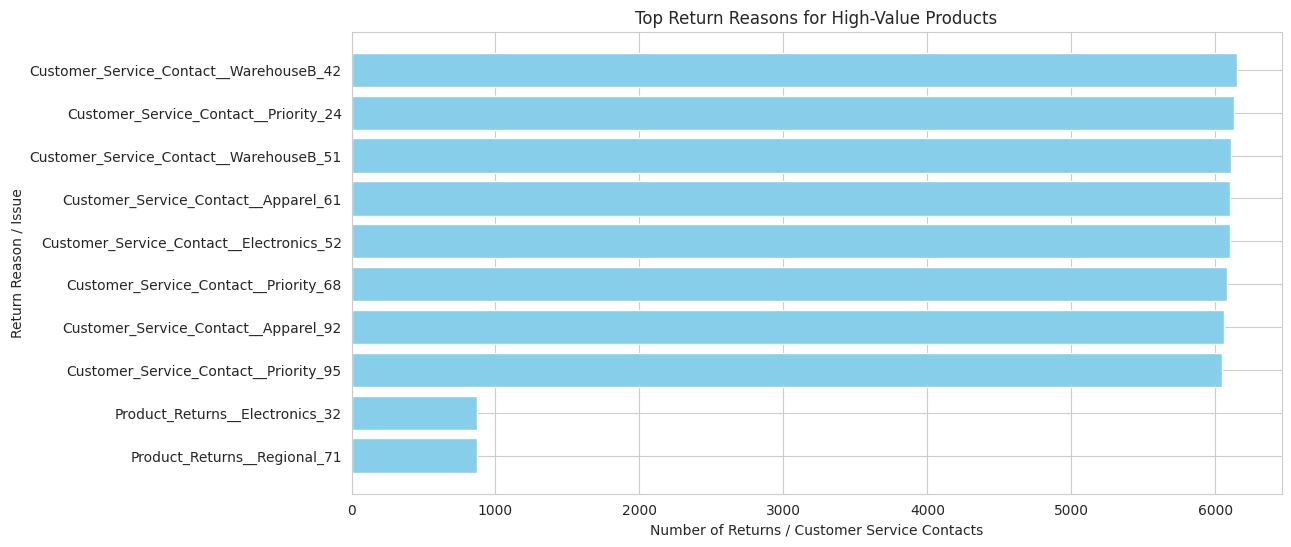

In [36]:
# =========================
# Step 12: Return Reasons for High-Value Products
# =========================

# Step 1: Identify top 20% orders by value
top_20_pct_value = orders['Total_Amount_USD'].quantile(0.8)
high_value_orders = orders[orders['Total_Amount_USD'] >= top_20_pct_value]

# Step 2: Select relevant return-related columns
return_columns = [col for col in orders.columns if 'Product_Returns' in col or 'Customer_Service_Contact' in col]

# Step 3: Aggregate return reasons counts
return_summary = high_value_orders[return_columns].sum().sort_values(ascending=False).reset_index()
return_summary.columns = ['Return_Reason', 'Count']

# Step 4: Display top return reasons
print("Top return/customer service issues for high-value products:")
print(return_summary.head(10))

# Step 5: Optional: visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.barh(return_summary['Return_Reason'].head(10), return_summary['Count'].head(10), color='skyblue')
plt.xlabel('Number of Returns / Customer Service Contacts')
plt.ylabel('Return Reason / Issue')
plt.title('Top Return Reasons for High-Value Products')
plt.gca().invert_yaxis()
plt.show()


In [35]:
# 1️⃣ Sirf column names dekhne ke liye
print(orders.columns.tolist())

# 2️⃣ Column types aur null values check karne ke liye
print(orders.info())

# 3️⃣ First 5 rows dekhne ke liye (sample data)
print(orders.head())


['Order_ID', 'Customer_ID', 'Order_Date', 'Order_Status', 'Total_Amount_USD', 'Total_Items_Count', 'Payment_Method', 'Shipping_Type', 'Shipping_Cost_USD', 'Coupon_Code_Used', 'Discount_Amount_USD', 'Tax_Amount_USD', 'Is_First_Time_Order', 'Referral_Channel', 'Processing_Days', 'Product_Returns__Apparel_1', 'Delivery_Rating_Score__Electronics_2', 'Time_to_Payment_Confirmation__Electronics_3', 'Product_Returns__Regional_4', 'Order_Refunded_Flag__Apparel_5', 'Order_Weight__WarehouseB_6', 'Unique_Product_Lines__Apparel_7', 'Product_Returns__Electronics_8', 'Time_to_Payment_Confirmation__Priority_9', 'Order_Weight__Apparel_10', 'Order_Refunded_Flag__Electronics_11', 'Order_Refunded_Flag__WarehouseB_12', 'Time_to_Payment_Confirmation__WarehouseB_13', 'Order_Weight__ReturnsPolicy_14', 'Unique_Product_Lines__Electronics_15', 'Warehouse_Location_Code__ReturnsPolicy_16', 'Delivery_Rating_Score__Electronics_17', 'Time_to_Payment_Confirmation__ReturnsPolicy_18', 'Product_Returns__Apparel_19', 'War

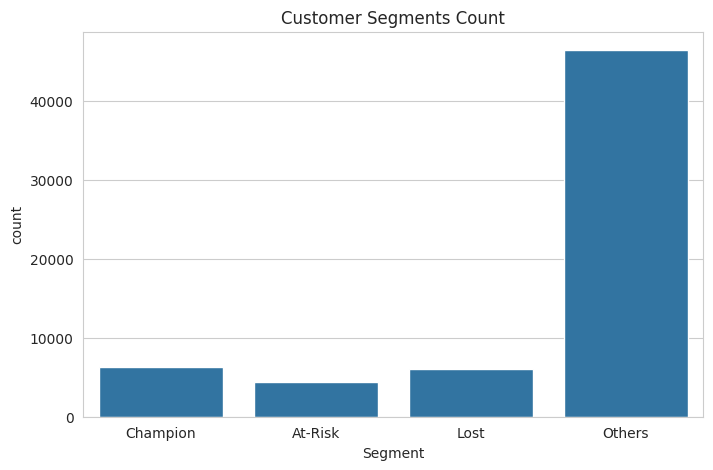

Sample RFM + CLV + Loyalty Tier Data:
  Customer_ID  Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Score  \
0  CUST000002      100          1   2472.46       4       1       4       414   
1  CUST000003       15          4    536.27       4       4       3       443   
2  CUST000006        6          3    484.11       4       4       3       443   
3  CUST000007      608          1    623.95       1       1       3       113   
4  CUST000008      585          1   1026.06       1       1       4       114   

    Segment Registration_Date  ... Avg_Review_Rating__Desktop_82  \
0    Others        2021-12-27  ...                          3.19   
1  Champion        2021-06-27  ...                          4.05   
2  Champion        2023-10-23  ...                          3.63   
3    Others        2023-08-15  ...                          2.61   
4    Others        2023-05-17  ...                          3.43   

  Unique_Products_Purchased__Q1_83  Lifetime_Orders__Q1_84  \
0   

In [39]:
# =========================
# Step 0: Imports
# =========================
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

# =========================
# Step 1: Assign tables (already loaded)
# =========================
# orders, customers, products
# orders columns: ['Order_ID', 'Customer_ID', 'Order_Date', 'Order_Status', 'Total_Amount_USD', ...]

# Convert dates
orders['Order_Date'] = pd.to_datetime(orders['Order_Date'])
analysis_date = orders['Order_Date'].max() + timedelta(days=1)

# =========================
# Step 2: Merge Orders and Customers (customer-level analysis)
# =========================
df_full = orders.merge(customers, on='Customer_ID', how='left')

# =========================
# Step 3: RFM Segmentation
# =========================
rfm = df_full.groupby('Customer_ID').agg({
    'Order_Date': lambda x: (analysis_date - x.max()).days,
    'Order_ID': 'nunique',
    'Total_Amount_USD': 'sum'
}).reset_index()

rfm.rename(columns={'Order_Date':'Recency','Order_ID':'Frequency','Total_Amount_USD':'Monetary'}, inplace=True)

rfm['R_Score'] = pd.qcut(rfm['Recency'].rank(method='first'), 4, labels=[4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

def segment_customer(row):
    if row['RFM_Score'] in ['444','443','434']:
        return 'Champion'
    elif row['RFM_Score'] in ['111','112','121']:
        return 'Lost'
    elif row['RFM_Score'] in ['211','212','221']:
        return 'At-Risk'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)
rfm_full = rfm.merge(customers, on='Customer_ID', how='left')

# =========================
# Step 4: Customer Lifetime Value (CLV)
# =========================
clv_df = df_full.groupby('Customer_ID').agg({
    'Order_ID':'nunique',
    'Total_Amount_USD':'sum',
    'Order_Date':[min,max]
}).reset_index()

clv_df.columns = ['Customer_ID','Frequency','Monetary','First_Purchase','Last_Purchase']
clv_df['Customer_Lifetime'] = (clv_df['Last_Purchase'] - clv_df['First_Purchase']).dt.days + 1
clv_df['AOV'] = clv_df['Monetary'] / clv_df['Frequency']
clv_df['CLV_Historical'] = clv_df['AOV'] * clv_df['Frequency']

# =========================
# Step 5: Churn Analysis
# =========================
customer_agg = df_full.groupby('Customer_ID').agg({
    'Order_Date':[min,max],
    'Order_ID':'nunique',
    'Total_Amount_USD':'sum'
}).reset_index()

customer_agg.columns = ['Customer_ID','First_Purchase','Last_Purchase','Frequency','Monetary']
customer_agg['Recency'] = (analysis_date - customer_agg['Last_Purchase']).dt.days
customer_agg['Churned'] = np.where(customer_agg['Recency']>180,1,0)

# =========================
# Step 6: Loyalty Tiers
# =========================
def loyalty_tier(row):
    if row['RFM_Score'] in ['444','443','434']:
        return 'Platinum'
    elif row['RFM_Score'] in ['344','334','343','433']:
        return 'Gold'
    elif row['RFM_Score'] in ['222','223','232','322','323']:
        return 'Silver'
    else:
        return 'Bronze'

rfm_full = rfm_full.merge(clv_df[['Customer_ID','AOV']], on='Customer_ID', how='left')
rfm_full['Loyalty_Tier'] = rfm_full.apply(loyalty_tier, axis=1)

# =========================
# Visualization Example: RFM Segments Count
# =========================
plt.figure(figsize=(8,5))
sns.countplot(data=rfm_full, x='Segment', order=['Champion','At-Risk','Lost','Others'])
plt.title('Customer Segments Count')
plt.show()

# =========================
# Outputs
# =========================
print("Sample RFM + CLV + Loyalty Tier Data:")
print(rfm_full.head())


In [38]:
# Check first 10 columns of orders
print(orders.columns[:10])

# Or check if specific column exists
print('Unique_Product_Lines__Apparel_1' in orders.columns)


Index(['Order_ID', 'Customer_ID', 'Order_Date', 'Order_Status',
       'Total_Amount_USD', 'Total_Items_Count', 'Payment_Method',
       'Shipping_Type', 'Shipping_Cost_USD', 'Coupon_Code_Used'],
      dtype='object')
False
